# ISM Delays: Tutorial 4

This notebook will build on the previous tutorials, showing more features of the `PsrSigSim`. Details will be given for new features, while other features have been discussed in the previous tutorial notebook. This notebook shows the details of different delays and effects due to the interstellar medium (ISM) that can be added to the simulated data.

We again simulate precision pulsar timing data with high signal-to-noise pulse profiles in order to clearly show the input pulse profile in the final simulated data product.

In [94]:
# import some useful packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# import the pulsar signal simulator
import psrsigsim as pss

## Setting up the Folded Signal

Here we will again set up the folded signal class as in previous introductory tutorials. We will again simulate a 20-minute-long observation total, with subintegrations of 1 minute. The other simulation parameters will be 64 frequency channels each 12.5 MHz wide (for 800 MHz bandwidth) observed with the Green Bank Telescope at L-band (1500 MHz center frequency).

We will simulate a real pulsar, J1713+0747, as we have a premade profile for this pulsar. The period, dm, and other relavent pulsar parameters come from the NANOGrav 11-yr data release.

In [95]:
# Define our signal variables.
f0 = 1500 # center observing frequecy in MHz
bw = 800.0 # observation MHz
Nf = 64 # number of frequency channels
# We define the pulse period early here so we can similarly define the frequency
period = 0.00457 # pulsar period in seconds for J1713+0747
f_samp = (1.0/period)*2048*10**-6 # sample rate of data in MHz (here 2048 samples across the pulse period)
sublen = 60.0 # subintegration length in seconds, or rate to dump data at
# Now we define our signal
signal_1713 = pss.signal.FilterBankSignal(fcent = f0, bandwidth = bw, Nsubband=Nf, sample_rate = f_samp,
                                       sublen = sublen, fold = True) # fold is set to `True`

## The Pulsar and Profiles

Now we will load the pulse profile as in Tutorial 3 and initialize a single `Pulsar` object. We will also make the pulses now so that we can add different ISM effects to them later.

In [96]:
# First we load the data array
path = 'psrsigsim/data/J1713+0747_profile.npy'
J1713_dataprof = np.load(path)

# Now we define the data profile
J1713_prof = pss.pulsar.DataProfile(J1713_dataprof)

In [97]:
# Define the values needed for the puslar
Smean = 0.009 # The mean flux of the pulsar, J1713+0747 at 1400 MHz from the ATNF pulsar catatlog, here 0.009 Jy
psr_name = "J1713+0747" # The name of our simulated pulsar

# Now we define the pulsar with the scaled J1713+0747 profiles
pulsar_J1713 = pss.pulsar.Pulsar(period, Smean, profiles=J1713_prof, name = psr_name)

In [98]:
# define the observation length
obslen = 60.0*20 # seconds, 20 minutes in total
# Make the pulses
pulsar_J1713.make_pulses(signal_1713, tobs = obslen)

## The Telescope

We will set up the `telescope` object in the same way as in the previous tutorials. Since we can set these up in any order, we will do these first to better show the different `ISM` properties later.

In [99]:
# We intialize the telescope object as the Green Bank Telescope
tscope = pss.telescope.telescope.GBT()

## The ISM

Here we will initialize the ISM class and show the various different delays that may be added to the simulated data that are due to the ISM or are specifically frequency-dependent delay. In particular these include dispersion due to the ISM, delays due to pulse scatter broadening, and other frequency dependent, or "FD", parameters as defined Zhu et al. 2015 and Arzoumanian et al. 2016.

In [100]:
# Define the ISM object, note that this class takes no initial arguements
ism_sim = pss.ism.ISM()

### Pulse Dispersion

We first show how to add dispersion of pulsars due to the ISM. This has been shown in previous tutorials as well. To do this, we first define the dispersion measure, or DM, the number of free electrons along the line of sight. This follows a frequency^-2 relation that can be found in the Handbook of Pulsar Astronomy, by Lorimer and Kramer, 2005. The DM we use here is the same as in the NANOGrav 11-yr par file for PSR J1713+0747. We show the pulses both before and after dispersion to show the effects. 

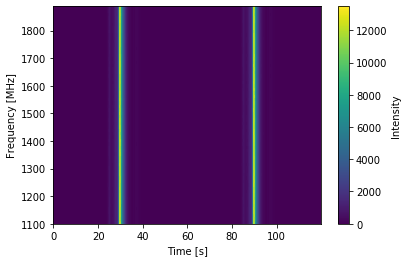

In [101]:
# We first plot the first two pulses in frequency-time space to show the undispersed pulses
time = np.linspace(0, obslen, len(signal_1713.data[0,:]))
# And the 2-D plot
plt.imshow(signal_1713.data[:,:4096], aspect = 'auto', interpolation='nearest', origin = 'lower', \
           extent = [min(time[:4096]), max(time[:4096]), signal_1713.dat_freq[0].value, signal_1713.dat_freq[-1].value])
plt.ylabel("Frequency [MHz]")
plt.xlabel("Time [s]")
plt.colorbar(label = "Intensity")
plt.show()
plt.close()

In [102]:
# Define the dispersion measure
dm =  15.921200 # pc cm^-3

In [103]:
# Now disperse the pulses. Once this is done, the psrsigsim remember that the simulated data have been dispersed.
ism_sim.disperse(signal_1713, dm)

98% dispersed in 0.143 seconds.

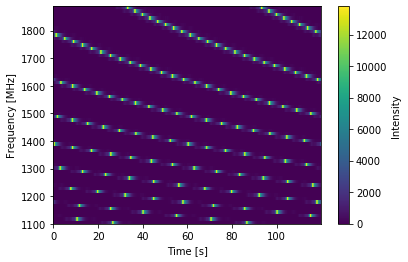

In [104]:
# Now we can plot the dispersed pulses
plt.imshow(signal_1713.data[:,:4096], aspect = 'auto', interpolation='nearest', origin = 'lower', \
           extent = [min(time[:4096]), max(time[:4096]), signal_1713.dat_freq[0].value, signal_1713.dat_freq[-1].value])
plt.ylabel("Frequency [MHz]")
plt.xlabel("Time [s]")
plt.colorbar(label = "Intensity")
plt.show()
plt.close()

One can clearly see the time delay as a function of observing frequency that has been added to the signal. However, addition effects can be added either separtely or in combination with dispersion.

### Frequency Dependent Delays

We can also add frequency dependent, or FD, delays to the simulated data. The formula for these FD parameters can be found in Zhu et al. 2015 and Arzoumanian et al. 2016. These delays are usually attributed to pulse profile evolution in frequency, but with the psrsigsim can also be directly injected into the simulated data without a frequency dependent pulse `Portait`.

The input for these delays are a list of coefficients (in units of seconds) that are used to determine the FD delay as computed in log-frequency space. FD delays are referenced such that the delay due to FD parameters is 0 at observing frequencies of 1 GHz.

In [105]:
# We can input any number of FD parameters as a list, but we will use the FD parameters in the NANOGrav 11-yr parfile
FD_J1713 = [-5.68565522e-04, 5.41762131e-04, -3.34764893e-04, 1.35695342e-04, -2.87410591e-05] # seconds

As delays due to FD parameters are usually much smaller than those from dispersion, we will re-instantiate the pulse signal to better show the delays added from FD parameters.

In [106]:
# Re-make the pulses
pulsar_J1713.make_pulses(signal_1713, tobs = obslen)

# Now add the FD parameter delay, this takes two arguements, the signal and the list of FD parameters
ism_sim.FD_shift(signal_1713, FD_J1713)

98% shifted in 0.113 seconds.

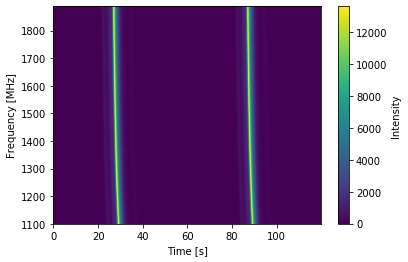

In [107]:
# Show the 2-D plot with the frequency dependent effects
plt.imshow(signal_1713.data[:,:4096], aspect = 'auto', interpolation='nearest', origin = 'lower', \
           extent = [min(time[:4096]), max(time[:4096]), signal_1713.dat_freq[0].value, signal_1713.dat_freq[-1].value])
plt.ylabel("Frequency [MHz]")
plt.xlabel("Time [s]")
plt.colorbar(label = "Intensity")
plt.show()
plt.close()

The shfit here is clearly visible at lower frequencies, though it is easy to see that the significance of this shift is much smaller than that from DM.

### Scattering Broadening Delays

We can also add delays due to pulse scatter broadening to the simulated data. We can do this two different ways, both of which will be demonstrated here. The first is by directly shifting the simulated profile in time by the appropriate scattering delay. The second is by convolving an exponential scattering tail, based on the input parameters, and then convolving it with the pulse profile. Both of these effects are frequency dependent, so the direct shifts are frequency dependent, and the exponential tails are similarly frequency dependent.

Note that delays from scattering due to the ISM tend to be very small for low DM pulsars at low radio frequencies, so the scattering delay we will use here will be largely inflated so the effects are visible by-eye.

In [108]:
# We will first define the scattering timescale and reference frequency for the timescale
tau_d = 1e-4 # seconds; note this is an unphysical number
ref_freq = 1500.0 # MHz, reference frequency of the scatter timescale input

#### Direct Shifting in Time

We start by showing how to directly shift the pulse profiles in time by the scattering timescale. We note that this does not add any pulse broadening, it simply shifts the peak of the pulse very slightly. Again, we remake the signal to better show the scatter broadening separately from the other ISM effects.

We also note here that `convolve=False` and `pulsar=None` are default inputs, and are not necessary for a direct shift.

In [109]:
# Re-make the pulses
pulsar_J1713.make_pulses(signal_1713, tobs = obslen)

# Now add the FD parameter delay, this takes two arguements, the signal and the list of FD parameters
ism_sim.scatter_broaden(signal_1713, tau_d, ref_freq, convolve = False, pulsar = None)

98% scatter shifted in 0.115 seconds.

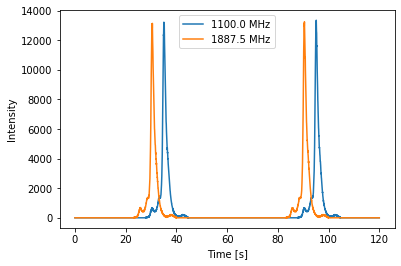

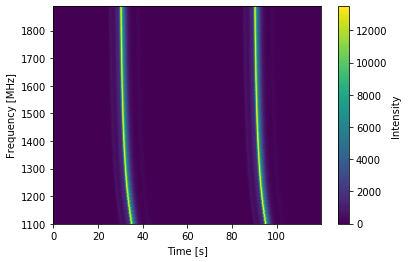

In [110]:
# Now we plot these profiles
# Since we know there are 2048 bins per pulse period, we can index the appropriate amount
plt.plot(time[:4096], signal_1713.data[0,:4096], label = signal_1713.dat_freq[0])
plt.plot(time[:4096], signal_1713.data[-1,:4096], label = signal_1713.dat_freq[-1])
plt.ylabel("Intensity")
plt.xlabel("Time [s]")
plt.legend(loc = 'best')
plt.show()
plt.close()

# Show the 2-D plot with the frequency dependent effects
plt.imshow(signal_1713.data[:,:4096], aspect = 'auto', interpolation='nearest', origin = 'lower', \
           extent = [min(time[:4096]), max(time[:4096]), signal_1713.dat_freq[0].value, signal_1713.dat_freq[-1].value])
plt.ylabel("Frequency [MHz]")
plt.xlabel("Time [s]")
plt.colorbar(label = "Intensity")
plt.show()
plt.close()

We can see the signal has been shifted in time as a function of frequency in both the profiles and in the 2-D power spectrum. But the input profiles themselves remain unchanged from the input profile, e.g. no exponential scattering convolution as been done.

#### Scattering Tail Convolution

Here we show how to scatter broaden the profiles themselves in order to add pulse scatter broadening delays. The inputs necessary to do this are very similar to directly shifting it, with the addition of changing `convolve=True` and adding the `Pulsar` object as input. Because this acts directly on the profiles, this must be done before `make_pulses()` is run, and cannot be undone.

We also note that the number of input profile channels must match the number of channels specified in the `Signal`. Here this is 64 channels, so we can reinstantiate the profile including the `Nchan=64` flag, and then make the pulsar again.

In [111]:
# Now we define the data profile
J1713_prof = pss.pulsar.DataProfile(J1713_dataprof, Nchan=64)

# Now we define the pulsar with the scaled J1713+0747 profiles
pulsar_J1713 = pss.pulsar.Pulsar(period, Smean, profiles=J1713_prof, name = psr_name)

# Now add the FD parameter delay, this takes two arguements, the signal and the list of FD parameters
ism_sim.scatter_broaden(signal_1713, tau_d, ref_freq, convolve = True, pulsar = pulsar_J1713)

# Re-make the pulses
pulsar_J1713.make_pulses(signal_1713, tobs = obslen)

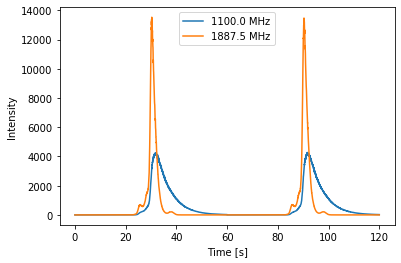

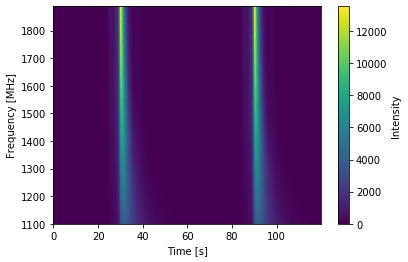

In [112]:
# Now we plot these profiles
# Since we know there are 2048 bins per pulse period, we can index the appropriate amount
plt.plot(time[:4096], signal_1713.data[0,:4096], label = signal_1713.dat_freq[0])
plt.plot(time[:4096], signal_1713.data[-1,:4096], label = signal_1713.dat_freq[-1])
plt.ylabel("Intensity")
plt.xlabel("Time [s]")
plt.legend(loc = 'best')
plt.show()
plt.close()

# Show the 2-D plot with the frequency dependent effects
plt.imshow(signal_1713.data[:,:4096], aspect = 'auto', interpolation='nearest', origin = 'lower', \
           extent = [min(time[:4096]), max(time[:4096]), signal_1713.dat_freq[0].value, signal_1713.dat_freq[-1].value])
plt.ylabel("Frequency [MHz]")
plt.xlabel("Time [s]")
plt.colorbar(label = "Intensity")
plt.show()
plt.close()

We can see now that the scattering tails have been convolved with the actual profiles, and this shows up in both the individual pulse profiles, which clearly show a shift in the peak of the pulse, as well as in the power spectrum, where the profile is clearly getting scattered out.

## Simulating the Scatter Broadened Pulsar

Now we will finish by `observe`ing the pulsar and looking at the data with the added noise.

In [113]:
# Observe with the telescope
tscope.observe(signal_1713, pulsar_J1713, system="Lband_GUPPI", noise=True)

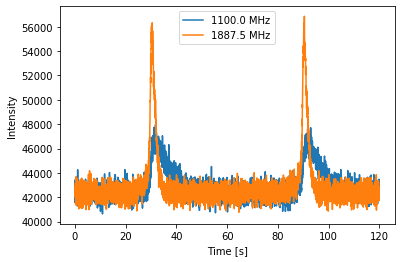

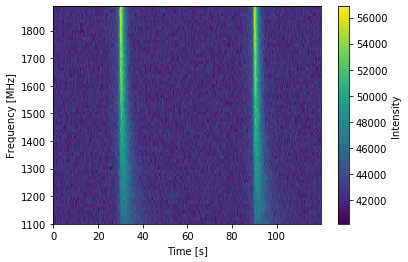

In [114]:
# Since we know there are 2048 bins per pulse period, we can index the appropriate amount
plt.plot(time[:4096], signal_1713.data[0,:4096], label = signal_1713.dat_freq[0])
plt.plot(time[:4096], signal_1713.data[-1,:4096], label = signal_1713.dat_freq[-1])
plt.ylabel("Intensity")
plt.xlabel("Time [s]")
plt.legend(loc = 'best')
plt.show()
plt.close()

# And the 2-D plot
plt.imshow(signal_1713.data[:,:4096], aspect = 'auto', interpolation='nearest', origin = 'lower', \
           extent = [min(time[:4096]), max(time[:4096]), signal_1713.dat_freq[0].value, signal_1713.dat_freq[-1].value])
plt.ylabel("Frequency [MHz]")
plt.xlabel("Time [s]")
plt.colorbar(label = "Intensity")
plt.show()
plt.close()